
Originally created by Chelsey McGowan-Yallop, SAMS-UHI (sa06cm@sams.ac.uk)

Modified by Muriel Dunn for fish mix analysis

This script uses model-predicted TS(f) spectra to train a machine learning
classifier, performs nested cross-validation, applies the classifier to
measured TS(f) spectra and outputs results files.

To use a different classifier, see the list of supported classifiers at:
https://github.com/hyperopt/hyperopt-sklearn and set as clf.

Sometimes the initial hyperparameter configuration selected by HyperOpt in each
split in the outer loop will be unsuccessful and all trials will fail. The
retry decorator forces it to try again until retry_limit is reached.

OUTPUT FILES:
    _NestedCV.pkl contains results of nested cross-validation procedure
    _Predictions.pkl contains measured TS(f) spectra with predicted labels
    _BestParams.pkl contains the optimal hyperparameters for the model
"""

In [35]:
import time
import os.path
import numpy as np
import pandas as pd
import pickle
import scipy
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import f1_score, confusion_matrix
#from sklearn.neighbors import KNeighborsClassifier
import hyperopt
from hyperopt import hp
from hyperopt import tpe
from hpsklearn import HyperoptEstimator, k_neighbors_classifier, svc, lightgbm_classification, random_forest_classifier
from sklearn.metrics import ConfusionMatrixDisplay
import lightgbm
from datetime import timedelta
from tenacity import retry, stop_after_attempt
import matplotlib.pyplot as plt

import sys, errno  


In [7]:
# -- USER-DETERMINED PARAMETERS -----------------------------------------------
letter_drive = 'F'
ppath = f'{letter_drive}:/AFKABAN/Pcod_190123/'
p2path = f'{letter_drive}:/AFKABAN/Pcod2_240123/'
apath = f'{letter_drive}:/AFKABAN/Acod_200123/'
pbpath = f'{letter_drive}:/AFKABAN/Pandalus_260123/'

# CLASSIFIER
unique_id = '13-03-2023_SVC_AFKABAN' # Unique ID for output file paths
clf = svc(unique_id)  # Classifier

# NESTED CROSS-VALIDATION
#preprocessing = [] # List of sklearn pre-processing modules
#ex_preprocessing = [] # As above, see help(HyperoptEstimator) for info
n_splits = 2 # Value of k for k-fold cross-validation in outer loop
n_folds = 2 # Value of k for k-fold cross-validation in inner loop
max_evals = 10 # No. of HyperOpt trials
timeout = 600 # HyperOpt trial timeout (seconds)
n_jobs = -1 # No. of jobs to run in parallel; -1 uses all processors
retry_limit = 3 # No. of times to retry before failing

# Read the dataframes

In [8]:
# Read pickle to open on Stokes
a_df = pd.read_feather(apath+'/a_tilt_df.feather')
p_df = pd.read_feather(ppath+'/p_tilt_df.feather')
p2_df = pd.read_feather(p2path+'/p2_tilt_df.feather')
pb_df = pd.read_feather(pbpath+'/pb_tilt_df.feather')

In [9]:
def select_ts_bandwidth(df):
    'Function to seperated target spectra from 120 kHz and 200 kHz echosounders'
    ind_120 = np.where(np.isnan(df['200.000']))[0]
    ts_s_120 = np.where(df.columns.values=='90.000')[0][0]
    ts_e_120 = np.where(df.columns.values=='162.000')[0][0]
    
    ind_200 = np.where(np.isnan(df['120.000']))[0]
    ts_s_200 = np.where(df.columns.values=='185.000')[0][0]
    ts_e_200 = np.where(df.columns.values=='255.000')[0][0]

    df_120 = df.iloc[ind_120,ts_s_120:ts_e_120]
    df_200 = df.iloc[ind_200,ts_s_200:ts_e_200]
    
    return df_120, df_200

In [10]:
a_df_120, a_df_200 = select_ts_bandwidth(a_df)
p_df_120, p_df_200 = select_ts_bandwidth(p_df)
p2_df_120, p2_df_200 = select_ts_bandwidth(p2_df)
pb_df_120, pb_df_200 = select_ts_bandwidth(pb_df)

# Classification functions

In [11]:
SED_120_df = pd.concat([a_df_120,p_df_120,p2_df_120,pb_df_120])

Species = np.concatenate([np.repeat('AtlanticCod',len(a_df_120)),np.repeat('PolarCod',len(p_df_120)),np.repeat('PolarCod',len(p2_df_120)),np.repeat('Pandalus',len(pb_df_120))])
SED_120_df['Species']=Species

In [12]:
measured_frequency = [float(i) for i in SED_120_df.columns[:-1].values]
n_model_f_bins = len(measured_frequency) # No. freq bins in model data
n_species = len(SED_120_df.Species.unique()) # No. species in model data

In [13]:
# -- WRANGLE DATA ---------------------------------------------------------
le = LabelEncoder() # Maps labels -> int (e.g. Atlantic cod -> 0, Polar cod -> 1)
SED_120_df['Species_le'] = le.fit_transform(SED_120_df.Species)
X = SED_120_df.iloc[:,0:-2] # Features, TS(f) only
X = X.reset_index(drop=True)
y = SED_120_df.Species_le # Labels
y = y.reset_index(drop=True)

In [ ]:
estim = HyperoptEstimator()


In [21]:
clf = hp.pchoice( 'my_name',
                 [( 0.4, random_forest_classifier('my_name.random_forest') ),
                  ( 0.3, svc('my_name.svc') ),
                  ( 0.3, k_neighbors_classifier('my_name.knn') )]
                )


In [22]:
model = HyperoptEstimator(classifier=clf)

In [23]:
model.fit(X,y)

100%|███████████████████████████████████████████████| 10/10 [00:05<00:00,  5.40s/trial, best loss: 0.17639361423711075]


# Script the classifier

In [24]:
@retry(stop=stop_after_attempt(retry_limit))
def nested_cv(X, y, model, n_splits, n_folds, unique_id):
    
    """
    This function performs nested cross-validation with Bayesian hyperparameter
    optimisation. It uses stratified k-fold cross-validation in both the inner
    and outer loops. After each outer loop, it outputs the results to a .pkl
    file. As there is an element of randomness to the optimisation procedure,
    sometimes all trials will fail. If you re-run the script, it will import
    the incomplete .pkl file and try again.
    
    Note that this is a modified version that uses F1 score as the evaluation
    metric. It also calculates class-specific F1 scores and confusion matrices,
    which are added to the output dataframe.
    
    PARAMETERS:
        X: data minus labels
        y: labels
        model: HyperoptEstimator object
        n_splits: # of splits to use in outer K-fold cross-validation
        n_folds: # of folds to use in inner K-fold cross-validation
        unique_id: Unique name string for file output path
    """
    
    cv = StratifiedKFold(n_splits=n_splits,
                         shuffle=True,
                         random_state=42) # Outer CV
    
    i_start = 0
    i_list = []
    results_df = None
    cv_path = unique_id + '_NestedCV.pkl'
        
    if os.path.isfile(cv_path) == True: # If CV is incomplete, resume
        results_df = pd.read_pickle(cv_path)
        i_start = results_df.Outer_fold.max() + 1
        print('Resuming cross-validation from fold ' + str(i_start + 1))
        
    # Generate indices to split data by StratifiedKFold
    # Append indices for each fold to list    
    for tr_i, te_i in cv.split(X,y):
        i_list.append([tr_i, te_i])
    
    # For each fold...
    for i in range(i_start, len(i_list)):
        results_list = []
        print('Beginning fold ' + str(i+1) + ' of ' + str(len(i_list)))
        
        # Split data into training and test tests
        X_train = X.loc[X.index.intersection(i_list[i][0])]
        y_train = y.loc[y.index.intersection(i_list[i][0])]
        X_test = X.loc[X.index.intersection(i_list[i][1])]
        y_test = y.loc[y.index.intersection(i_list[i][1])]

        start = time.time()
        
        # Fit the HyperoptEstimator to training data (optimise model)
        model.fit(X_train,
                  y_train,
                  n_folds=n_folds, # Inner stratified k-fold CV
                  cv_shuffle=True)
        
        end = time.time()
        duration = end - start

        # Use optimised model to predict labels for test data
        y_pred = model.predict(X_test)
        score = f1_score(y_test, y_pred, average='weighted') # Evaluate
        
        # Everything below: formats and/or calculates results for output file
        sorted_labels = np.sort(y_test.unique())
        unweighted_score = f1_score(y_test, y_pred,
                                    average=None,
                                    labels=sorted_labels)
        c_matrix = confusion_matrix(y_test, y_pred,
                                    labels=sorted_labels)

        for trial in range(len(model.trials.trials)):
                if model.trials.trials[trial].get('result').get('status') == 'ok':
                    trial_loss = model.trials.trials[trial].get('result').get('loss')
                    trial_duration = model.trials.trials[trial].get('result').get('duration')
                else:
                    trial_loss = np.nan
                    trial_duration = np.nan
            
                results_list.append([i,
                                     score,
                                     unweighted_score,
                                     le.inverse_transform(sorted_labels),
                                     c_matrix,
                                     duration,
                                     trial,
                                     trial_loss,
                                     trial_duration])
        
        append_df = pd.DataFrame(results_list,
                                 columns=['Outer_fold',
                                          'Outer_score',
                                          'Outer_unweighted_scores',
                                          'Outer_unweighted_score_labels',
                                          'Outer_confusion_matrix',
                                          'Outer_training_duration',
                                          'Trial',
                                          'Trial_loss',
                                          'Trial_duration'])
        if i == i_start:
            if results_df is not None:
                final_df = pd.concat([results_df,
                                      append_df],
                                      ignore_index=True)
            else:
                final_df = append_df
            final_df.to_pickle(cv_path)
        
        else:
            results_df = pd.read_pickle(cv_path)
            final_df = pd.concat([results_df,
                                  append_df],
                                  ignore_index=True)
            final_df.to_pickle(cv_path)
     

In [25]:
def f1_loss(y_true, y_pred):
    """
    Custom loss function for HyperOpt.
    Uses F1 score instead of accuracy score, as the latter is inappropriate
    for multi-class classification.
    """
    return 1.0 - f1_score(y_true, y_pred, average='weighted')
    

In [26]:
nested_cv(X, y, model, n_splits, n_folds, 'test_againagainagain')

Beginning fold 1 of 2
100%|███████████████████████████████████████████████| 10/10 [00:03<00:00,  3.88s/trial, best loss: 0.07967752067846301]


C:\Users\mbd\anaconda3\envs\AZKABANML\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Beginning fold 2 of 2
100%|█████████████████████████████████████████████| 10/10 [22:47<00:00, 1367.58s/trial, best loss: 0.07308135273793315]


C:\Users\mbd\anaconda3\envs\AZKABANML\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


In [ ]:
def main_classify():    

    ""
    #path: srt. path to dataframes
    #detections: str. Type of detections, SED, trackSED or trackavg.
    
    

    # -- RESTRUCTURE MODEL DATA -----------------------------------------------

    measured_frequency = [float(i) for i in mix_df.columns.values]
    n_model_f_bins = len(measured_frequency) # No. freq bins in model data
    n_species = len(labelled_df.Species.unique()) # No. species in model data

    # -- WRANGLE DATA ---------------------------------------------------------

    le = LabelEncoder() # Maps labels -> int (e.g. Copepods -> 0, Krill -> 1)
    labelled_df['Species_le'] = le.fit_transform(labelled_df.Species)
    X = labelled_df.iloc[:,14+1:-15-2] # Features, TS(f) only
    y = labelled_df.Species_le # Labels


    # -- NESTED CROSS-VALIDATION ----------------------------------------------

    model = HyperoptEstimator(classifier = clf,
                              preprocessing = preprocessing,
                              ex_preprocs = ex_preprocessing,
                              algo = tpe.suggest,
                              trial_timeout = timeout,
                              loss_fn = f1_loss,
                              max_evals = max_evals,
                              n_jobs = n_jobs)
    model

    nested_cv(X, y, model, n_splits, n_folds, unique_id)

    # -- RETRAIN MODEL --------------------------------------------------------

    print('Retraining model on full dataset')

    model = HyperoptEstimator(classifier = clf,
                              preprocessing = preprocessing,
                              ex_preprocs = ex_preprocessing,
                              algo = tpe.suggest,
                              trial_timeout = timeout,
                              loss_fn = f1_loss,
                              max_evals = max_evals,
                              n_jobs = n_jobs)

    model.fit(X, y, n_folds=n_folds, cv_shuffle=True)

    # -- PREDICT CLASSES FOR NEW DATA -----------------------------------------

    print('Classifying new data')

    y_pred = model.predict(measured_X) # Predict classes for measured TS(f)
    y_pred = le.inverse_transform(y_pred) # Transform labels back to species

    # -- OUTPUT RESULTS -------------------------------------------------------

    mix_df['Prediction'] = y_pred
    mix_df.to_pickle(unique_id + '_Predictions.pkl')

    with open(unique_id + '_BestParams.pkl', 'wb') as handle:
        pickle.dump(model.best_model(), handle)




In [45]:
model.best_model()

{'learner': RandomForestClassifier(class_weight='balanced_subsample', criterion='entropy',
                        max_features=None, min_samples_leaf=9,
                        min_samples_split=3, n_estimators=47, n_jobs=1,
                        random_state=0, verbose=False),
 'preprocs': (StandardScaler(),),
 'ex_preprocs': ()}

In [43]:
c = pd.read_pickle('test_againagainagain_NestedCV.pkl')
b = pd.read_pickle('test_againagainagain_BestParams.pkl')

FileNotFoundError: [Errno 2] No such file or directory: 'test_againagainagain_BestParams.pkl'

In [32]:
def print_F1_mean(classifier):
    cv_df = classifier
    
    print('Mean class-weighted F1 score for : '
          + str(round(cv_df.Outer_score.mean(), 2))
          + ' ± '
          + str(round(cv_df.Outer_score.std(), 2)))

    mean_class_scores = np.mean(np.vstack(cv_df.Outer_unweighted_scores.values), axis=0)
    std_class_scores = np.std(np.vstack(cv_df.Outer_unweighted_scores.values), axis=0)

    for i, species in enumerate(cv_df.Outer_unweighted_score_labels.values[0]):
        print('Mean F1 score for ' + species + ': '
             + str(round(mean_class_scores[i], 2))
             + ' ± '
             + str(round(std_class_scores[i], 2)))

In [33]:
print_F1_mean(c)

Mean class-weighted F1 score for : 0.93 ± 0.0
Mean F1 score for AtlanticCod: 0.76 ± 0.01
Mean F1 score for Pandalus: 1.0 ± 0.0
Mean F1 score for PolarCod: 0.96 ± 0.0


In [42]:
c

,Outer_fold,Outer_score,Outer_unweighted_scores,Outer_unweighted_score_labels,Outer_confusion_matrix,Outer_training_duration,Trial,Trial_loss,Trial_duration
0,0,0.930849,"[0.7711598746081504, 0.9940298507462687, 0.957...","[AtlanticCod, Pandalus, PolarCod]","[[1107, 0, 326], [0, 333, 4], [331, 0, 7450]]",713.253502,0,0.331588,2.006159
1,0,0.930849,"[0.7711598746081504, 0.9940298507462687, 0.957...","[AtlanticCod, Pandalus, PolarCod]","[[1107, 0, 326], [0, 333, 4], [331, 0, 7450]]",713.253502,1,0.093812,0.823790
2,0,0.930849,"[0.7711598746081504, 0.9940298507462687, 0.957...","[AtlanticCod, Pandalus, PolarCod]","[[1107, 0, 326], [0, 333, 4], [331, 0, 7450]]",713.253502,2,0.094859,5.485395
3,0,0.930849,"[0.7711598746081504, 0.9940298507462687, 0.957...","[AtlanticCod, Pandalus, PolarCod]","[[1107, 0, 326], [0, 333, 4], [331, 0, 7450]]",713.253502,3,0.143126,8.721001
4,0,0.930849,"[0.7711598746081504, 0.9940298507462687, 0.957...","[AtlanticCod, Pandalus, PolarCod]","[[1107, 0, 326], [0, 333, 4], [331, 0, 7450]]",713.253502,4,0.079678,284.922451
5,0,0.930849,"[0.7711598746081504, 0.9940298507462687, 0.957...","[AtlanticCod, Pandalus, PolarCod]","[[1107, 0, 326], [0, 333, 4], [331, 0, 7450]]",713.253502,5,0.399016,13.881897
6,0,0.930849,"[0.7711598746081504, 0.9940298507462687, 0.957...","[AtlanticCod, Pandalus, PolarCod]","[[1107, 0, 326], [0, 333, 4], [331, 0, 7450]]",713.253502,6,0.105853,1.252661
7,0,0.930849,"[0.7711598746081504, 0.9940298507462687, 0.957...","[AtlanticCod, Pandalus, PolarCod]","[[1107, 0, 326], [0, 333, 4], [331, 0, 7450]]",713.253502,7,0.185216,2.634978
8,0,0.930849,"[0.7711598746081504, 0.9940298507462687, 0.957...","[AtlanticCod, Pandalus, PolarCod]","[[1107, 0, 326], [0, 333, 4], [331, 0, 7450]]",713.253502,8,0.140718,1.357053
9,0,0.930849,"[0.7711598746081504, 0.9940298507462687, 0.957...","[AtlanticCod, Pandalus, PolarCod]","[[1107, 0, 326], [0, 333, 4], [331, 0, 7450]]",713.253502,9,0.097163,0.177653


Text(0.5, 1.0, 'kNN')

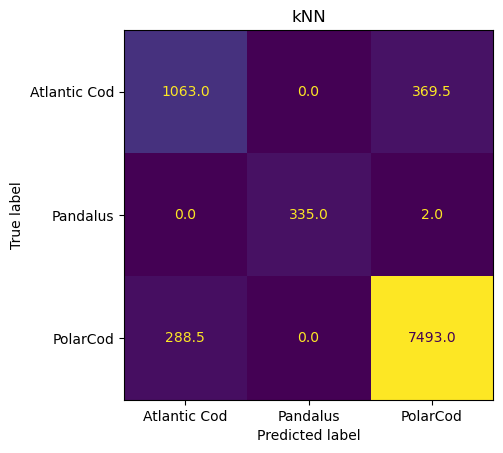

In [40]:
fig,ax = plt.subplots(1,1)
cmp_kNN = ConfusionMatrixDisplay(c.Outer_confusion_matrix.mean(),
                             display_labels=['Atlantic Cod', 'Pandalus','PolarCod'])
cmp_kNN.plot(ax=ax, colorbar=False, values_format='.1f')
ax.set_title('kNN')